# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Есть пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Показатели скважин**:
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- Один баррель сырья приносит 450 рублей дохода;
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;

**Задача**:

- Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
- Нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Анализ возможной прибыли и рисков необходимо выполнить техникой *Bootstrap.*

## Загрузка и подготовка данных

### Импорт библиотек и данных

In [1]:
# для анализа и работы с данных
import pandas as pd
import numpy as np

# для графического отображения результатов
import seaborn as sns
import matplotlib.pyplot as plt

# алгоритмы машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# метрики для алгоритмов ML
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error)

# для игнорирования ошибки в логистической регрессии
import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
# загрузка датафрейма (try - локально, except - по ссылке)
try:
    df0 = pd.read_csv('/data/geo_data_0.csv')
    df1 = pd.read_csv('/data/geo_data_1.csv')
    df2 = pd.read_csv('/data/geo_data_2.csv')
    
except:
    df0 = pd.read_csv('https://ССЫЛКА/geo_data_0.csv')
    df1= pd.read_csv('https://ССЫЛКА/geo_data_1.csv')
    df2 = pd.read_csv('https://ССЫЛКА/geo_data_2.csv')

### Общая информация о датафреймах

Функией df_info пройдемся по основным показателям датафрейма df

In [3]:
# создадим список датафреймов для дальнейших вычислений
df_all = [df0, df1, df2]

In [4]:
# функиия для вывода основных показателей трех датафреймов
def df_info(df):

    print("-"*100)
    print('Общая информамия о датафрейме:')
    print("-"*100)
    print(df.info())
    
    print("-"*100)
    print('Первые 5 строк таблицы')
    print("-"*100)
    display(df.head(5))
    
    print("-"*100)
    print('Последние 5 строк таблицы')
    print("-"*100)
    display(df.tail(5))
    
    print("-"*100)
    print('Количество пропусков')
    print("-"*100)
    print(df.isnull().sum().sort_values(ascending=False))
    
    print("-"*100)
    print('Статистические данные датафрейма')
    print("-"*100)
    display(np.round(df.describe(), 2).T)
    
    print("-"*100)
    print('Количество дубликатов:')
    print("-"*100)
    display(df.duplicated().sum())
    
    print("-"*100)
    print('Визуализация пропущенных данных по строкам датафрейма')
    print("-"*100)
    sns.heatmap(df.isna().transpose(), cmap="coolwarm", cbar_kws={'label': 'Пропуски в данных'})
    plt.show()
    
    print("-"*100)
    print('Матрица корреляции') 
    print("-"*100)
    sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='coolwarm')
    plt.show()
    
    print("-"*100)
    print('Общая гистограмма датафрейма')
    print("-"*100)
    df.hist(figsize = (10, 10), color='#08cc9e', ec='#fc5a14')
    plt.show()
    
    print("/"*100)
    print('Следующий датафрейм')    

----------------------------------------------------------------------------------------------------
Общая информамия о датафрейме:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы
----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


----------------------------------------------------------------------------------------------------
Последние 5 строк таблицы
----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


----------------------------------------------------------------------------------------------------
Количество пропусков
----------------------------------------------------------------------------------------------------
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
----------------------------------------------------------------------------------------------------
Статистические данные датафрейма
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,100000.0,0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,100000.0,2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,100000.0,92.50,44.29,0.00,56.50,91.85,128.56,185.36


----------------------------------------------------------------------------------------------------
Количество дубликатов:
----------------------------------------------------------------------------------------------------


0

----------------------------------------------------------------------------------------------------
Визуализация пропущенных данных по строкам датафрейма
----------------------------------------------------------------------------------------------------


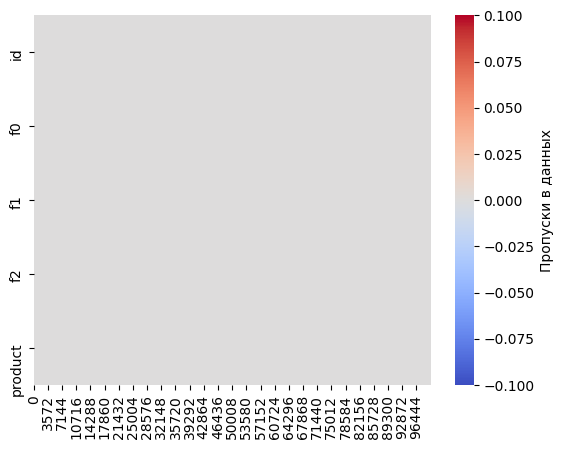

----------------------------------------------------------------------------------------------------
Матрица корреляции
----------------------------------------------------------------------------------------------------


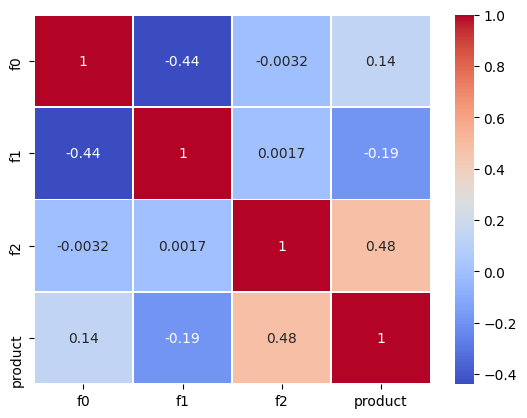

----------------------------------------------------------------------------------------------------
Общая гистограмма датафрейма
----------------------------------------------------------------------------------------------------


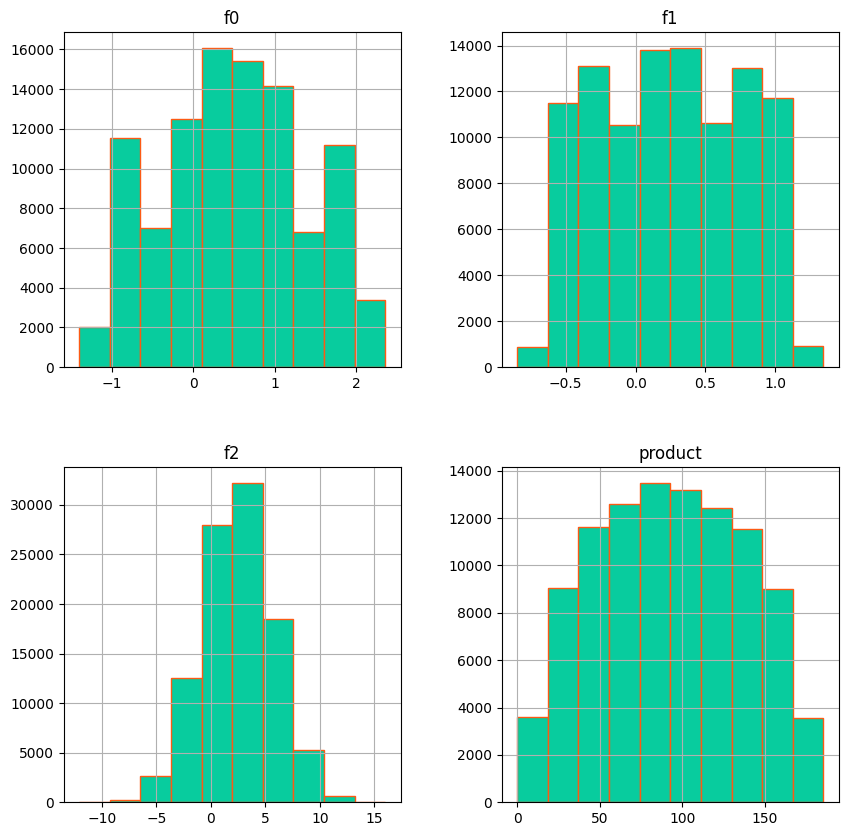

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм
----------------------------------------------------------------------------------------------------
Общая информамия о датафрейме:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы
-----------------------------------------------------------------------------------

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


----------------------------------------------------------------------------------------------------
Последние 5 строк таблицы
----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


----------------------------------------------------------------------------------------------------
Количество пропусков
----------------------------------------------------------------------------------------------------
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
----------------------------------------------------------------------------------------------------
Статистические данные датафрейма
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,100000.0,-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,100000.0,2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,100000.0,68.83,45.94,0.00,26.95,57.09,107.81,137.95


----------------------------------------------------------------------------------------------------
Количество дубликатов:
----------------------------------------------------------------------------------------------------


0

----------------------------------------------------------------------------------------------------
Визуализация пропущенных данных по строкам датафрейма
----------------------------------------------------------------------------------------------------


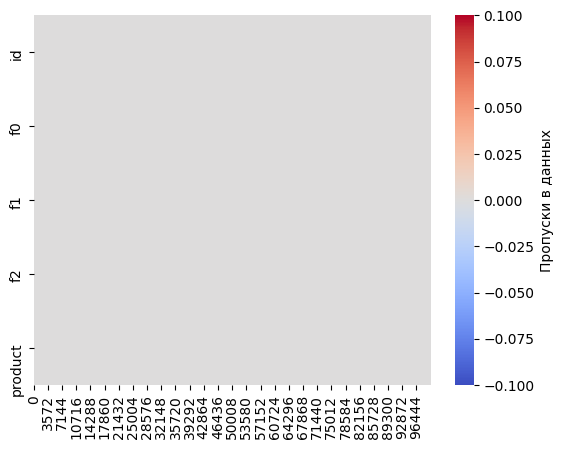

----------------------------------------------------------------------------------------------------
Матрица корреляции
----------------------------------------------------------------------------------------------------


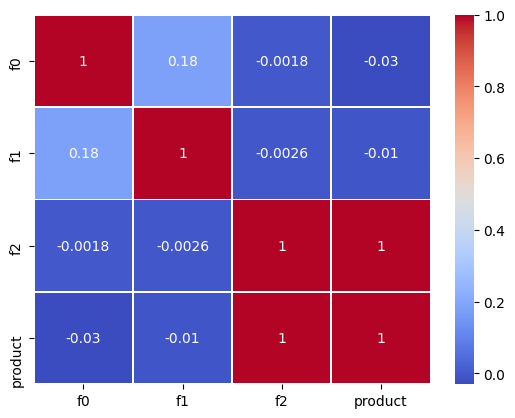

----------------------------------------------------------------------------------------------------
Общая гистограмма датафрейма
----------------------------------------------------------------------------------------------------


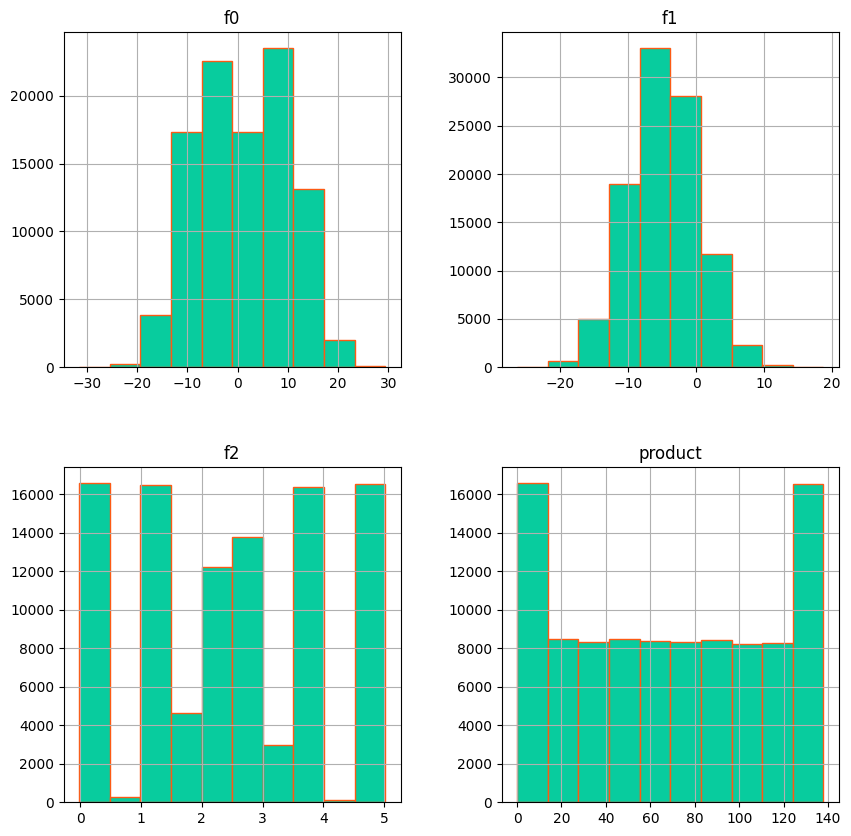

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм
----------------------------------------------------------------------------------------------------
Общая информамия о датафрейме:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы
-----------------------------------------------------------------------------------

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


----------------------------------------------------------------------------------------------------
Последние 5 строк таблицы
----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


----------------------------------------------------------------------------------------------------
Количество пропусков
----------------------------------------------------------------------------------------------------
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
----------------------------------------------------------------------------------------------------
Статистические данные датафрейма
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.0,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,100000.0,-0.0,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,100000.0,2.5,3.47,-11.97,0.13,2.48,4.86,16.74
product,100000.0,95.0,44.75,0.00,59.45,94.93,130.60,190.03


----------------------------------------------------------------------------------------------------
Количество дубликатов:
----------------------------------------------------------------------------------------------------


0

----------------------------------------------------------------------------------------------------
Визуализация пропущенных данных по строкам датафрейма
----------------------------------------------------------------------------------------------------


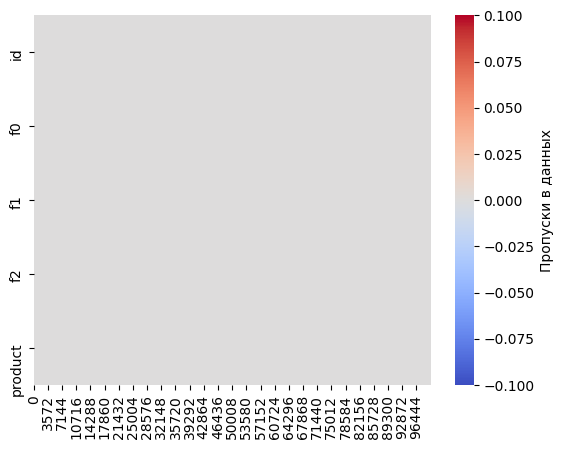

----------------------------------------------------------------------------------------------------
Матрица корреляции
----------------------------------------------------------------------------------------------------


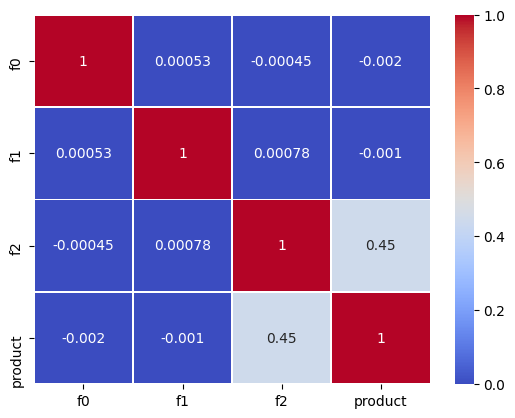

----------------------------------------------------------------------------------------------------
Общая гистограмма датафрейма
----------------------------------------------------------------------------------------------------


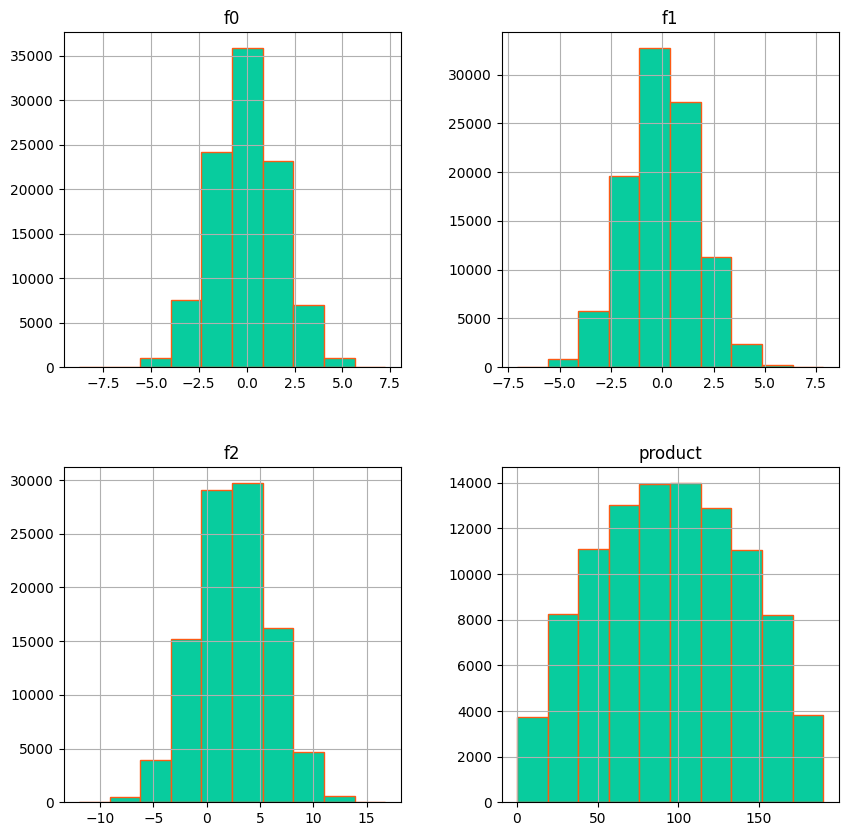

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм


In [5]:
# цикл for для перебора датафреймов df0, df1, df2 в списке df_all и вывода общей информации по ним из функции df_info
for df in df_all:
  df_info(df)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.1.2:**
    
На основе полученной общей информации о датафреймах:

1) Для всех датафреймов
- количество строк 100000
- в колонке id - строковые значения
- в колонках f0, f1, f2 - значения типа float64
- пропусков нет
- дубликатов нет

2) df0:
-  между признаками f0 и f1 есть обратная корреляция на -0.41
- между признаками product и f2 прямая корреляция на 0.48
- По общей гистограмме всех признаков датафрейма наблюдается нормальное распределение значений

2) df21
- между признаками product и f2 прямая корреляция равная 1
- По общей гистограмме признаков датафрейма наблюдается нормальное распределение значений для колонок f0 и f1. В колонках f2 и product значения равномерно распределены, есть выбросы

3) df2:
- между признаками product и f2 прямая корреляция на 0.45
- По общей гистограмме всех признаков датафрейма наблюдается нормальное распределение значений

### Описание данных

В датафреймах данные геологоразведки трёх регионов

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

### Предобработка данных

В датафрейме есть признаки (колонки с **id** — уникальным идентификатором скважины), которые могут оказать негативное влияние на обучение моделей. Удалим их

In [6]:
# пройдемся циклом по трем датафреймам для удаления колонок с признаком id
for df in df_all:
    df.drop(columns = ['id'], inplace = True)
    
    # проверим результат удаления id
    print(df.info())
    print("/"*100)
    print('Следующий датафрейм')    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
////////////////////////////////////////////////////////////////////////////////////////////////////
Сл

### Анализ признаков в датафреймах

#### Диаграммы размаха

In [7]:
# функция для диаграмм размаха нескольких метрик
def box_plot(df):
    plt.figure(figsize=(11, 1))
    sns.boxplot(x=df['f0'])
    plt.show()
    
    plt.figure(figsize=(11, 1))
    sns.boxplot(x=df['f1'])
    plt.show()
    
    plt.figure(figsize=(11, 1))
    sns.boxplot(x=df['f2'])
    plt.show()
    
    plt.figure(figsize=(11, 1))
    sns.boxplot(x=df['product'])
    plt.show()

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм


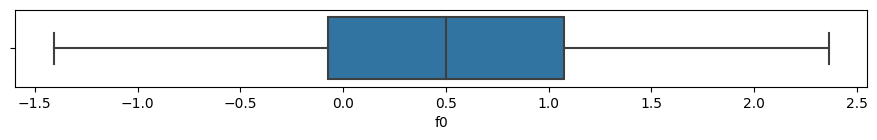

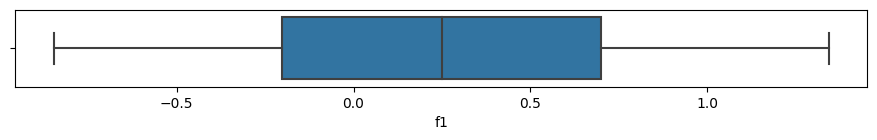

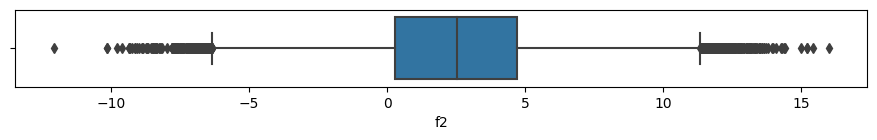

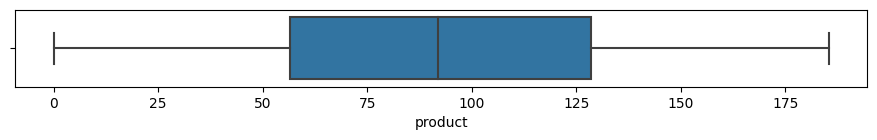

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм


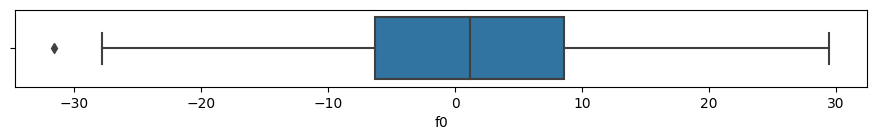

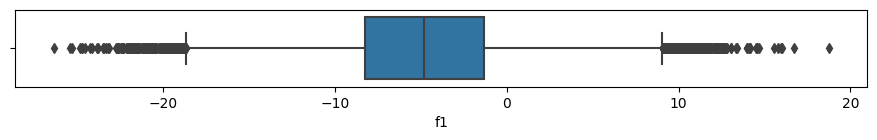

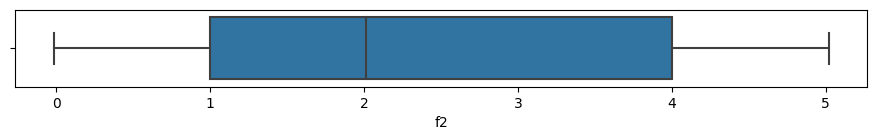

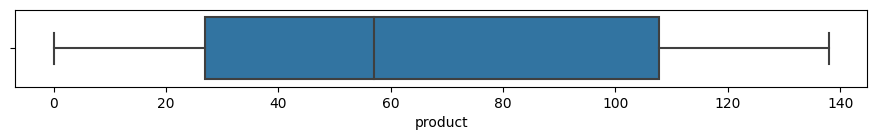

////////////////////////////////////////////////////////////////////////////////////////////////////
Следующий датафрейм


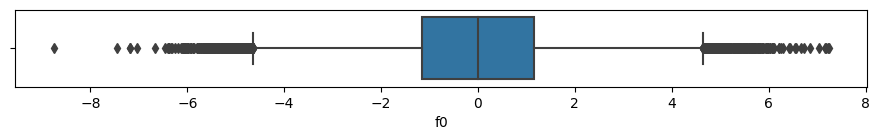

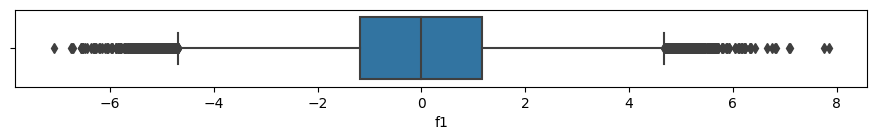

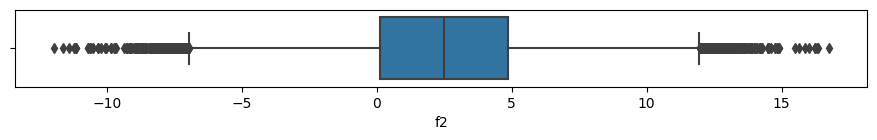

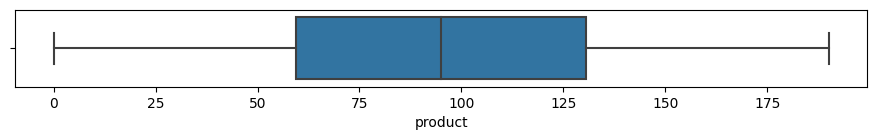

In [8]:
# цикл для вызова предыдущей функции по трем датафреймам
for df in df_all:
    print("/"*100)
    print('Следующий датафрейм')
    box_plot(df)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы по диаграммам размаха п.1.5.1:**
    
- по признаку f0: в df2 наблюдается много выбросов, в df0 и df1 длина усов немного больше длины ящиков. Во всех трех датафреймах наблюдается различия по диапазону значений ящиков по Q1, Q3
- по признаку f1: в df1 и df2 наблюдается много выбросов. Во всех трех датафреймах длина усов больше длины ящика, а также различия по диапазону значений ящиков по Q1, Q3
- по признаку f2: в df0 и df2 наблюдается много выбросов, в них же длина усов больше длины ящиков. В df1 длина ящика больше длины усов. По диапазону значений df0 и df2 схожи между собой, df1 отличается от df0 и df2
- по признаку product все три датафрейма схожи между собой



#### Диаграммы значений

Отобразим на одной диаграмме данные для трех датафреймов **df0, df1, df2** по признаку **f0**

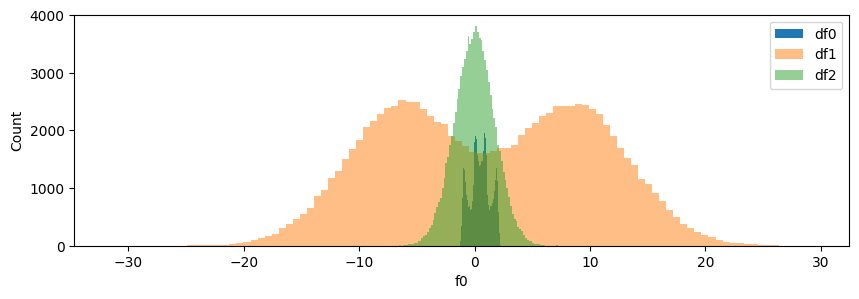

In [9]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(10, 3))

df0['f0'].plot(kind = 'hist', alpha=1, bins = 100, label='df0')
df1['f0'].plot(kind = 'hist', alpha=0.5, bins = 100, label='df1')
df2['f0'].plot(kind = 'hist', alpha=0.5, bins = 100, label='df2')

# Добавляем легенду и название осей
ax.legend(loc='upper right')
ax.set_xlabel('f0')
ax.set_ylabel('Count')

# Отображаем график
plt.show()

Отобразим на одной диаграмме данные для трех датафреймов **df0, df1, df2** по признаку **f1**

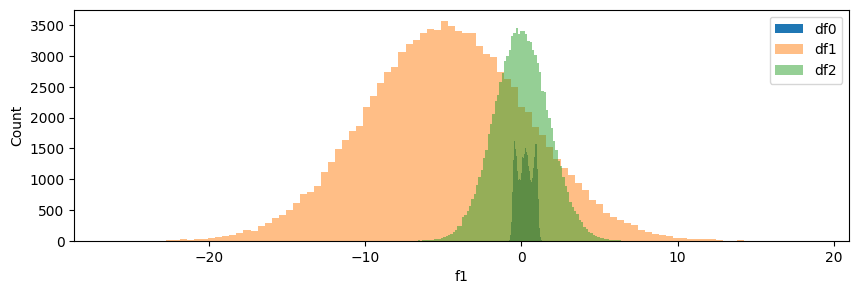

In [10]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(10, 3))

df0['f1'].plot(kind = 'hist', alpha=1, bins = 100, label='df0')
df1['f1'].plot(kind = 'hist', alpha=0.5, bins = 100, label='df1')
df2['f1'].plot(kind = 'hist', alpha=0.5, bins = 100, label='df2')

# Добавляем легенду и название осей
ax.legend(loc='upper right')
ax.set_xlabel('f1')
ax.set_ylabel('Count')

# Отображаем график
plt.show()

Отобразим на одной диаграмме данные для трех датафреймов **df0, df1, df2** по признаку **f2**

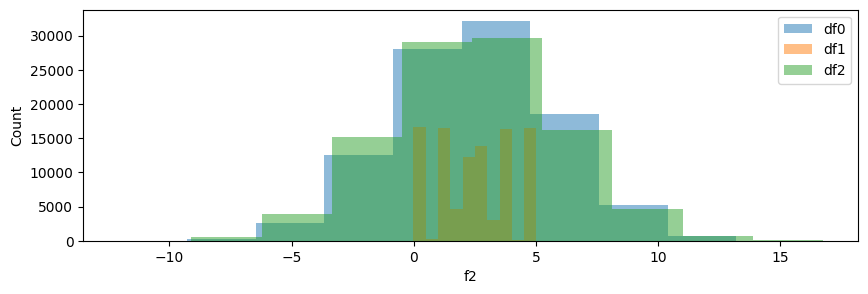

In [11]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(10, 3))

# Отображаем данные для каждого датафрейма на одном графике
ax.hist(df0['f2'], alpha=0.5, label='df0')
ax.hist(df1['f2'], alpha=0.5, label='df1')
ax.hist(df2['f2'], alpha=0.5, label='df2')

# Добавляем легенду и название осей
ax.legend(loc='upper right')
ax.set_xlabel('f2')
ax.set_ylabel('Count')

# Отображаем график
plt.show()

Отобразим на одной диаграмме данные для трех датафреймов **df0, df1, df2** по признаку **product**

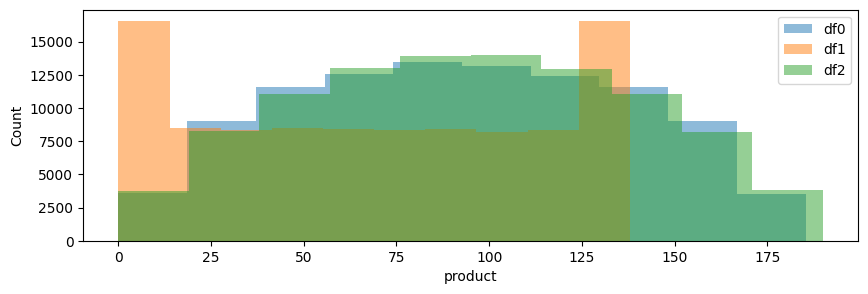

In [12]:
# Создаем фигуру и оси для графика
fig, ax = plt.subplots(figsize=(10, 3))

# Отображаем данные для каждого датафрейма на одном графике
ax.hist(df0['product'], alpha=0.5, label='df0')
ax.hist(df1['product'], alpha=0.5, label='df1')
ax.hist(df2['product'], alpha=0.5, label='df2')

# Добавляем легенду и название осей
ax.legend(loc='upper right')
ax.set_xlabel('product')
ax.set_ylabel('Count')

# Отображаем график
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы по признакам f0, f1, f2, product:**

- по всем датафреймам в признаках f0, f1, f2 наблюдается близкое к нормалному распределению значений
- в признаке **product** второго региона (df1) заметно выделяется распределение значений по сравнению с другими регионами (где значения имеют нормальный характер распределения со средним в диапазоне 80-100 тыс.баррелей). Во втором регионе есть явные выбросы: много скважин с нулевым запасом сырья, также много как и с макссимальным запасом в 125 тыс.баррелей

---
Рассммотрим подробнее распределение сырья по скважинам в каждом регионе отдельно

In [13]:
# Построим гистограммы по столбцу product.
def hist(seria, bins, xlim_max, ylim_max):
    plt.figure(figsize=[10,3])

    plt.hist(seria, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

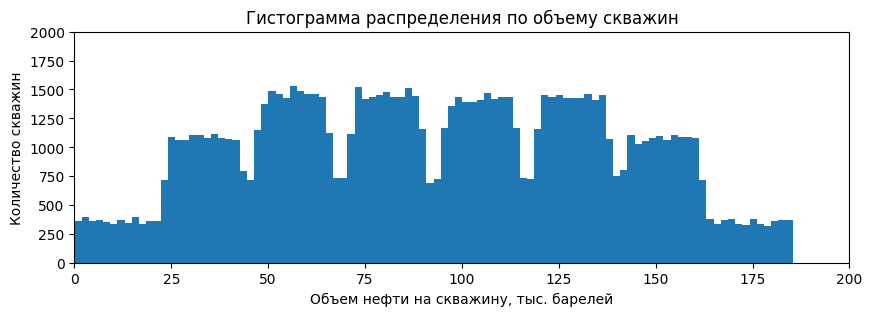

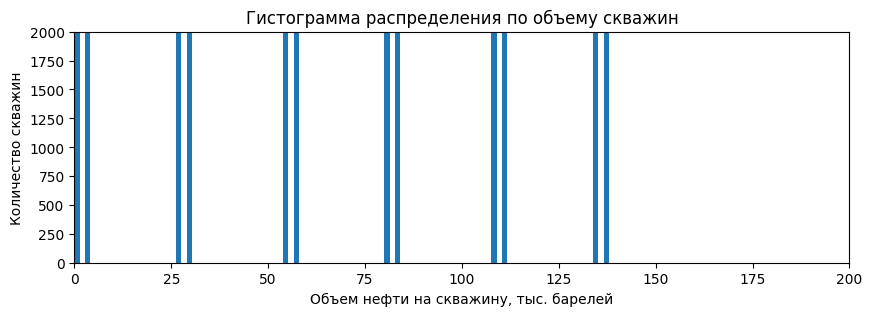

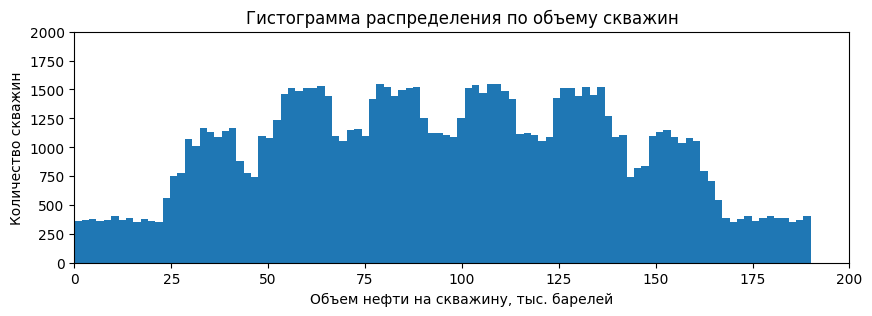

In [14]:
for df in df_all:
    hist(df['product'], 100, 200, 2000)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы по гистограммам распределения объема сырья в скважинах:**

Как и было описано ранее, в первом и третьем регионе запасы нефти в скважинах стремится к нормальному распределению, а вот во втором регионе похоже на некорректность заполнения данными

## Обучение и проверка модели

### Разбивка данных на выборки

Выборка датафрейма **df0**

In [15]:
# извлекаем признаки
X_df0 = df0.drop(['product'], axis=1)

# создание переменной для целевого признака
y_df0 = df0['product']

# разделяем данные на обучающую и валидационную выборки в соотношении 75/25 (обучающая/валидационная)
X_df0_train, X_df0_valid, y_df0_train, y_df0_valid, = train_test_split(
    X_df0, y_df0, test_size=0.25, random_state=112)

# вывод размерности выборок
print("Название выборки / Количество строк / Количество признаков")
print("Обучающая выборка df0:", X_df0_train.shape)
print("Валидационная выборка df0:", X_df0_valid.shape)

Название выборки / Количество строк / Количество признаков
Обучающая выборка df0: (75000, 3)
Валидационная выборка df0: (25000, 3)


Выборка датафрейма **df1**

In [16]:
# извлекаем признаки
X_df1 = df1.drop(['product'], axis=1)

# создание переменной для целевого признака
y_df1 = df1['product']

# разделяем данные на обучающую и валидационную выборки в соотношении 75/25 (обучающая/валидационная)
X_df1_train, X_df1_valid, y_df1_train, y_df1_valid, = train_test_split(
    X_df1, y_df1, test_size=0.25, random_state=112)

# вывод размерности выборок
print("Название выборки / Количество строк / Количество признаков")
print("Обучающая выборка df0:", X_df1_train.shape)
print("Валидационная выборка df0:", X_df1_valid.shape)

Название выборки / Количество строк / Количество признаков
Обучающая выборка df0: (75000, 3)
Валидационная выборка df0: (25000, 3)


Выборка датафрейма **df2**

In [17]:
# извлекаем признаки
X_df2 = df2.drop(['product'], axis=1)

# создание переменной для целевого признака
y_df2 = df2['product']

# разделяем данные на обучающую и валидационную выборки в соотношении 75/25 (обучающая/валидационная)
X_df2_train, X_df2_valid, y_df2_train, y_df2_valid, = train_test_split(
    X_df2, y_df2, test_size=0.25, random_state=112)

# вывод размерности выборок
print("Название выборки / Количество строк / Количество признаков")
print("Обучающая выборка df0:", X_df2_train.shape)
print("Валидационная выборка df0:", X_df2_valid.shape)

Название выборки / Количество строк / Количество признаков
Обучающая выборка df0: (75000, 3)
Валидационная выборка df0: (25000, 3)


<div style='border:solid blue 3px; padding: 20px'>
    
**Вывод п.2.1:**

 Выполнена разбивка для трех датафреймов на Обучающую выборку размером 75000 строк и 3 признаками, а также на Валидационную выборка размером 25000 строк и 3 признаками

### Масштабирование признаков

**ТЕОРИЯ:**

Многие алгоритмы машинного обучения зависят от масштаба признаков. Если значения признаков имеют разный масштаб, то это может привести к проблемам в работе алгоритма, таким как снижение точности предсказаний и увеличение времени обучения. Масштабирование признаков помогает улучшить производительность алгоритма и повысить качество его работы.

Масштабирование признаков в машинном обучении означает приведение значений признаков к одному диапазону. Это может быть выполнено путем нормализации (приведения к диапазону от 0 до 1) или стандартизации (приведения к нормальному распределению со средним значением 0 и стандартным отклонением 1).

Масштабирование признаков необходимо в машинном обучении в следующих случаях:

1. Когда признаки имеют различные единицы измерения. В этом случае масштабирование позволяет привести все признаки к одному масштабу.

2. Когда признаки имеют различный диапазон значений. В этом случае масштабирование позволяет уменьшить влияние признаков с большими значениями на обучение модели.

3. Когда используется метод, который чувствителен к масштабу признаков. Например, метод k-ближайших соседей (k-NN) использует расстояние между объектами для классификации или регрессии. Если признаки не масштабированы, то признаки с большими значениями будут оказывать большее влияние на расстояние и, следовательно, на результаты метода.

4. Когда используется метод градиентного спуска для обучения модели. Метод градиентного спуска может сходиться быстрее, если признаки масштабированы.

**ВЫВОД:** признаки необходимо масштабировать 

In [18]:
df1.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [19]:
# Для масштабирования соберем в список колонки с численными признаками
numeric = ['f0', 'f1', 'f2']

# Создадим объекты структуры для списка numeric
scaler_df0 = StandardScaler()
scaler_df1 = StandardScaler()
scaler_df2 = StandardScaler()

# Настроим их на обучающих данных. Настройка — это вычисление среднего и дисперсии:
scaler_df0.fit(X_df0_train[numeric])
scaler_df1.fit(X_df1_train[numeric])
scaler_df2.fit(X_df2_train[numeric])

# Масштабируем численные признаки обучающей выборки
X_df0_train[numeric] = scaler_df0.transform(X_df0_train[numeric])
X_df1_train[numeric] = scaler_df1.transform(X_df1_train[numeric])
X_df2_train[numeric] = scaler_df2.transform(X_df2_train[numeric])

# Масштабируем численные признаки валидационной выборки 
X_df0_valid[numeric] = scaler_df0.transform(X_df0_valid[numeric])
X_df1_valid[numeric] = scaler_df1.transform(X_df1_valid[numeric])
X_df2_valid[numeric] = scaler_df2.transform(X_df2_valid[numeric])

<div style='border:solid blue 3px; padding: 20px'>
    
**Вывод п.2.2:**

Обоснована необходимость выполнения масщтабирования признаков в трех датафреймах

### Обучение моделей

Обучим модели линейной регрессии на тренеировочных выборках, предсказания на валидационных выборках, посчитаем метрики RMSE, MAE и средний запас сырья

In [20]:
# функция для обучения модели линейной регрессии и вычисления метрик RMSE, MAE, среднего запаса сырья
def df_model(X_df_train, X_df_valid, y_df_train, y_df_valid):
    model = LinearRegression() 
    model.fit(X_df_train, y_df_train)
    predicted = model.predict(X_df_valid)
    print('MAE: {:.3f}'.format(mean_absolute_error(y_df_valid, predicted)))
    print('RMSE: {:.3f}'.format(mean_squared_error(y_df_valid, predicted)** 0.5))
    print('Средний запас предсказанного сырья: {:.3f}'.format(predicted.mean()))
    return predicted

Регион первый (df0):

In [21]:
pred_0=df_model(X_df0_train, X_df0_valid, y_df0_train, y_df0_valid)

MAE: 31.093
RMSE: 37.793
Средний запас предсказанного сырья: 92.658


Регион второй (df1):

In [22]:
pred_1=df_model(X_df1_train, X_df1_valid, y_df1_train, y_df1_valid)

MAE: 0.718
RMSE: 0.890
Средний запас предсказанного сырья: 68.471


Регион третий (df2):

In [23]:
pred_2=df_model(X_df2_train, X_df2_valid, y_df2_train, y_df2_valid)

MAE: 32.922
RMSE: 40.158
Средний запас предсказанного сырья: 94.756


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.3:**

- модели обучены линейной регрессии на тренеировочных выборках, предсказания на валидационных выборках
- посчитаны метрики RMSE, MAE и средний запас сырья
- максимальное значение предсказанного среднего значения сырья в сквважинах приходится на Регион 3 с количеством 94.76 тыс. баррелей, наименьшее значение в Регионе 2 с количеством 68.47 тыс. баррелей
- по данным расчетам третий регион выглядит наиболее предпочтительным
    

## Подготовка к расчёту прибыли

**Условия задачи:**
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей
- Один баррель сырья приносит 450 рублей дохода
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

### Переменные для расчетов

In [24]:
# опишем переменные
# Исследование 500 точек при разведке региона 
wells = 500

# 200 лучших точек для разработки скважин
best_wells = 200

# Бюджет на разработку всех скважин в регионе
budget_wells = 1e10

# Доход от одного барреля сырья = 450 рублей
barrel_income = 450

# Вероятность убытков должна быть меньше 2.5%
loss_probability = 0.025

### Достаточный объём сырья для безубыточной разработки новых скважин

In [25]:
# здесь делим Бюджет на разработку всех скважин в регионе / Доход от одного барреля сырья = 450 рублей
breakeven_volume = budget_wells / (barrel_income * 1000) 
print("-"*100)
print('Минимальный объём сырья для безубыточной разработки в регионе, тыс.баррелей:',
      np.round(breakeven_volume), 2)
print("-"*100)

----------------------------------------------------------------------------------------------------
Минимальный объём сырья для безубыточной разработки в регионе, тыс.баррелей: 22222.0 2
----------------------------------------------------------------------------------------------------


По техническому заданию необходимо выбирать 200 лучших мест для разработки скважин. Посчитаем необходимый безубыточный объем выработки сырья для всего региона

In [26]:
# посчитаем необходимы объем сырья на 200 лучших точек
region_volume = breakeven_volume / best_wells
print("-"*100)
print('Минимальный объём сырья для безубыточной разработки одной скважины региона, тыс.баррелей:',
      np.round(region_volume, 2))
print("-"*100)

----------------------------------------------------------------------------------------------------
Минимальный объём сырья для безубыточной разработки одной скважины региона, тыс.баррелей: 111.11
----------------------------------------------------------------------------------------------------


Сравним полученный объём сырья со средним запасом в каждом регионе

In [27]:
# переменные для подсчета среднего значения сырья по датафреймам df0, df1, df2 в колонке 'product'
product_mean_df0 = np.round(df0['product'].mean(), 2)
product_mean_df1 = np.round(df1['product'].mean(), 2)
product_mean_df2 = np.round(df2['product'].mean(), 2)

# переменные для подсчета доходности скважин в среднем по регионам product_mean_df
# относительно минимального объёма сырья для безубыточной разработки одной скважины региона region_volume
profit_df0 = np.round((product_mean_df0-region_volume)/region_volume*100, 2)
profit_df1 = np.round((product_mean_df1-region_volume)/region_volume*100, 2)
profit_df2 = np.round((product_mean_df2-region_volume)/region_volume*100, 2)

# вывод значений
print("-"*100)
print('Средний объем запасов сырья в скважинах по регионам:')
print('- В первом регионе, тыс.баррелей:', product_mean_df0)
print('Процент отклонения от минимального объёма сырья для безубыточной разработки, %.2f ' %profit_df0)
print('- Во втором регионе, тыс.баррелей:', product_mean_df1)
print('Процент отклонения от минимального объёма сырья для безубыточной разработки, %.2f ' %profit_df1)
print('- В третьем регионе, тыс.баррелей:', product_mean_df2)
print('Процент отклонения от минимального объёма сырья для безубыточной разработки, %.2f ' %profit_df2)
print("-"*100)

----------------------------------------------------------------------------------------------------
Средний объем запасов сырья в скважинах по регионам:
- В первом регионе, тыс.баррелей: 92.5
Процент отклонения от минимального объёма сырья для безубыточной разработки, -16.75 
- Во втором регионе, тыс.баррелей: 68.83
Процент отклонения от минимального объёма сырья для безубыточной разработки, -38.05 
- В третьем регионе, тыс.баррелей: 95.0
Процент отклонения от минимального объёма сырья для безубыточной разработки, -14.50 
----------------------------------------------------------------------------------------------------


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.2:**

Все три региона в среднем имеют отрицательную доходность по скважинам. То есть, если выбрать 200 произвольных скважин, то вероятнее всего они окажутся убыточными. Надо искать лучшие скважины

## Расчёт прибыли и рисков 

### Прибыль по предсказаниям модели

Выберем наилучшие скважины. Сделаем привязку индексов скважин по модели  с предсказаниям, отсорируем по убыванию, оставим первые 200 лучших скважин

In [28]:
# Регион 1, выборка двухсот лучших скважин на предсказанной модели
pred_0_max = pd.Series(pred_0, index=y_df0_valid.index).sort_values(ascending=False)
sel_max_df0 = pred_0_max[:200]

# Регион 2, выборка двухсот лучших скважин на предсказанной модели
pred_1_max = pd.Series(pred_1, index=y_df1_valid.index).sort_values(ascending=False)
sel_max_df1 = pred_1_max[:200]

# Регион 3, выборка двухсот лучших скважин на предсказанной модели
pred_2_max = pd.Series(pred_2, index=y_df2_valid.index).sort_values(ascending=False)
sel_max_df2 = pred_2_max[:200]

Просуммируем объем лучших двухсот скважин по трем регионам

In [29]:
# Регион 1
sel_max_df0_sum = sel_max_df0.sum()
print('Объем сырья в первом регионе: %.2f тыс.баррелей' %sel_max_df0_sum)

# Регион 2
sel_max_df1_sum = sel_max_df1.sum()
print('Объем сырья во втором регионе: %.2f тыс.баррелей' %sel_max_df1_sum)

# Регион 3
sel_max_df2_sum = sel_max_df2.sum()
print('Объем сырья в третьем: %.2f тыс.баррелей' %sel_max_df2_sum)

Объем сырья в первом регионе: 30828.29 тыс.баррелей
Объем сырья во втором регионе: 27753.29 тыс.баррелей
Объем сырья в третьем: 29656.88 тыс.баррелей


Рассчитаем прибыль для полученного объёма сырья

In [30]:
# Регион 1
profit_pred_0=((sel_max_df0_sum * barrel_income*1000) - budget_wells) / 1e9
print('Прибыль в первом регионе: %.2f млрд.рублей' %profit_pred_0)

# Регион 2
profit_pred_1=((sel_max_df1_sum * barrel_income*1000) - budget_wells) / 1e9
print('Прибыль во втором регионе: %.2f млрд.рублей' %profit_pred_1)

# Регион 3
profit_pred_2=((sel_max_df2_sum * barrel_income*1000) - budget_wells) / 1e9
print('Прибыль в третьем регионе: %.2f млрд.рублей' %profit_pred_2)

Прибыль в первом регионе: 3.87 млрд.рублей
Прибыль во втором регионе: 2.49 млрд.рублей
Прибыль в третьем регионе: 3.35 млрд.рублей


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.4.1:**

 максимальная прибыль достигнута в первом регионе

### Риски и прибыль для каждого региона

Создадим функцию для дальнейшего расчета рисков и прибыли для каждого региона

In [31]:
# Подсчет прибыли
def revenue(target, probabilities, best_wells_count, bar_income, bud_wel):
    
    # новый датафрейм, отсортированный по убыванию
    prob_sort = probabilities.sort_values(ascending=False)
    
    # делаем выборку топ-200
    selected = target[prob_sort.index][:best_wells_count]
    
    # вычисляем прибыль
    profit=(bar_income*1000 * selected.sum() - bud_wel)/1000
    
    # суммируем объем выборки топ-200
    volume=selected.sum()
    
    # вычисляем среднее выборки топ-200
    selected_mean=selected.mean()
    
    # возвращаем три значения функции
    return volume, profit, selected_mean

---
Проведем процедуру Bootstrap для трех регионов

In [32]:
# Функция с применением техники Bootstrap для 1000 выборок
def income_def (target, predicted, study,development, bud_wel, loss_proba, bar_income):
    
    # создадим генератор случайных чисел RandomState() из модуля numpy.random
    state = np.random.RandomState(112)
    
    # приводим датафрейм target к виду без индексов
    target=target.reset_index(drop=True)
    
    # создаем пустые списки для прибыли и объема
    profit_sample = []
    volume_sample=[]
    
    # запускаем цикл, который будет повторяться 1000 раз
    for i in range(1000):
        
        # выбираем случайную подвыборку из датафрейма target размером study
        # метод sample возвращает новый датафрейм с выбранными строками
        target_subsample = target.sample(n=study, replace=True, random_state=state)
        
        # выбираем соответствующие вероятности успеха из списка predicted 
        # с помощью метода Series, который принимает на вход индексы выбранных строк из датафрейма target_subsample
        probs_subsample = pd.Series(predicted)[target_subsample.index]
        
        # вызываем функцию revenue, которая вычисляет прибыль, объем и среднее значение выбранных скважин
        volume, profit, selected_mean = revenue(target_subsample, probs_subsample, development, barrel_income, bud_wel)
        
        # сохраняем результаты в соответствующие списки
        profit_sample.append(profit)        
        volume_sample.append(volume)

    # преобразуем списки в пандасовские серии
    profit_sample = pd.Series(profit_sample)     
    profit_mean = profit_sample.mean()
    
    # вычисляем доверительный интервал для прибыли с помощью методов quantile и count
    # quantile возвращает значение, ниже которого находится определенная доля значений выборки
    # count возвращает количество элементов в выборке
    low = profit_sample.quantile(loss_proba) 
    up  = profit_sample.quantile(1-loss_proba) 
    
    # вычисляем риск убытка как долю значений выборки, меньших нуля, умноженную на 100
    risk = (profit_sample < 0).mean()*100     
    
    # вычисляем средний объем месторождения, средний общий объем по региону и среднюю прибыль
    volume_sample = pd.Series(volume_sample)
    volume_mean = volume_sample.mean()
    print("Ср. общий объем по всему региону:", round(volume_mean, 2), 'тыс.баррелей')    
    print("Ср. объем по скважинам:", round(selected_mean, 2), 'тыс.баррелей')
    print("Ср. прибыль:", round(profit_mean, 2), 'млн.руб')
    print("Риск убытка:", round(risk, 3), '%')
    print("Доверительный интервал: от", round(low, 2),'до ', round(up, 2) )

    # возвращаем четыре значения: среднюю прибыль, средний объем, среднее значение выбранных скважин и риск убытка
    return profit_mean,volume_mean,selected_mean,risk    

In [33]:
profit_mean_0, volume_mean_0, selected_mean_0, risk_0 = income_def(y_df0_valid,
                                                                   pred_0,
                                                                   wells,
                                                                   best_wells,
                                                                   budget_wells,
                                                                   loss_probability,
                                                                   barrel_income)

Ср. общий объем по всему региону: 23185.32 тыс.баррелей
Ср. объем по скважинам: 115.69 тыс.баррелей
Ср. прибыль: 433394.34 млн.руб
Риск убытка: 5.5 %
Доверительный интервал: от -60939.37 до  941082.64


In [34]:
profit_mean_1, volume_mean_1, selected_mean_1, risk_1 = income_def(y_df1_valid,
                                                                   pred_1,
                                                                   wells,
                                                                   best_wells,
                                                                   budget_wells,
                                                                   loss_probability,
                                                                   barrel_income)

Ср. общий объем по всему региону: 23263.05 тыс.баррелей
Ср. объем по скважинам: 120.34 тыс.баррелей
Ср. прибыль: 468373.67 млн.руб
Риск убытка: 1.4 %
Доверительный интервал: от 44498.67 до  874042.29


In [35]:
profit_mean_2, volume_mean_2, selected_mean_2, risk_2 = income_def(y_df2_valid,
                                                                   pred_2,
                                                                   wells,
                                                                   best_wells,
                                                                   budget_wells,
                                                                   loss_probability,
                                                                   barrel_income)

Ср. общий объем по всему региону: 22987.49 тыс.баррелей
Ср. объем по скважинам: 121.65 тыс.баррелей
Ср. прибыль: 344370.71 млн.руб
Риск убытка: 10.5 %
Доверительный интервал: от -207328.0 до  883884.4


---
Создадим сводную таблицу результатов расчетов

In [36]:
# создаем имена и присваиваем значения
region = ['регион_0',
          'регион_1',
          'регион_2']

profit = [profit_mean_0,
         profit_mean_1,
         profit_mean_2]

volume = [volume_mean_0,
          volume_mean_1,
          volume_mean_2]

selected = [selected_mean_0,
            selected_mean_1,
            selected_mean_2]

risk = [risk_0,
        risk_1,
        risk_2]

# создаем датафрейм из созданных имен и значений
best_region = pd.DataFrame({'Регион' : region,
                            'Ср. прибыль, млн.руб.' : profit, 
                            'Ср. объем по всему региону, тыс.баррелей' : volume,
                            'Ср. объем по скважинам, тыс.баррелей' : selected,
                            'Риск убытков %' : risk})

# сортируем таблицу по колонке со средней прибылью
best_region.sort_values('Ср. прибыль, млн.руб.', ascending=False)

,Регион,"Ср. прибыль, млн.руб.","Ср. объем по всему региону, тыс.баррелей","Ср. объем по скважинам, тыс.баррелей",Риск убытков %
1,регион_1,468373.672515,23263.052606,120.342855,1.4
0,регион_0,433394.342490,23185.320761,115.687676,5.5
2,регион_2,344370.714128,22987.490476,121.649096,10.5


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.4.2:**

На основе сводной таблицы делаем итоговый вывод в сторону выбора Региона №1 за счет наибольшой прибыли и наименьших рисков

<div style='border:solid violet 5px; padding: 20px'>

**Краткий обзор проделанной работы**

1. Раздел: Подготовка и анализ данных
- загружены и подготовлены данные
- импортированы необходимые библиотеки
- выведена общая информация о датафреймах
- приведено описание данных
- выполнена предобработка данных: удалены признаки **id**
- проведен анализ признаков в датафреймах
- построены диаграммы размаха, диаграммы значений по признаками **f0, f1, f2, product** трех датафреймов

2. Раздел: Обучение модели
- сделана разбивка данных на выборки
- обосновано необходимости масштабирования признаков
- обучены модели для трех датафреймов

3. Раздел: Подготовка к расчёту прибыли
- записаны переменные для расчетов
- приведен расчет достаточного объёма сырья для безубыточной разработки новых скважин

4. Раздел: Расчёт прибыли и рисков 
- выполнен расчет прибыли по предсказаниям модели
- рассчитаны риски и прибыль для каждого региона
- составлена сводна таблица результатов расчетов

**Главные выводы:**
На основе сводной таблицы делаем выбор в сторону Региона №1 за счет наибольшой прибылью в 468373 млн.руб и наименьших рисков в размере 1.4%